In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.metrics import top_k_categorical_accuracy
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

C:\Users\Dell\AppData\Local\Temp\ipykernel_2556\108837032.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
# Load CIFAR-10 dataset
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

In [3]:
# Normalize pixel values to be between 0 and 1
x_train_full, x_test = x_train_full / 255.0, x_test / 255.0

In [4]:
# CIFAR-10 class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
# Display random sample of 10 images from each class
def display_random_images_per_class(images, labels, classes, num_samples=10):
    fig, axs = plt.subplots(len(classes), num_samples, figsize=(15, 15))

    for i, class_name in enumerate(classes):
        class_indices = np.where(labels == i)[0]
        random_indices = np.random.choice(class_indices, num_samples, replace=False)
        
        for j, idx in enumerate(random_indices):
            axs[i, j].imshow(images[idx])
            axs[i, j].set_title(class_name)
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()


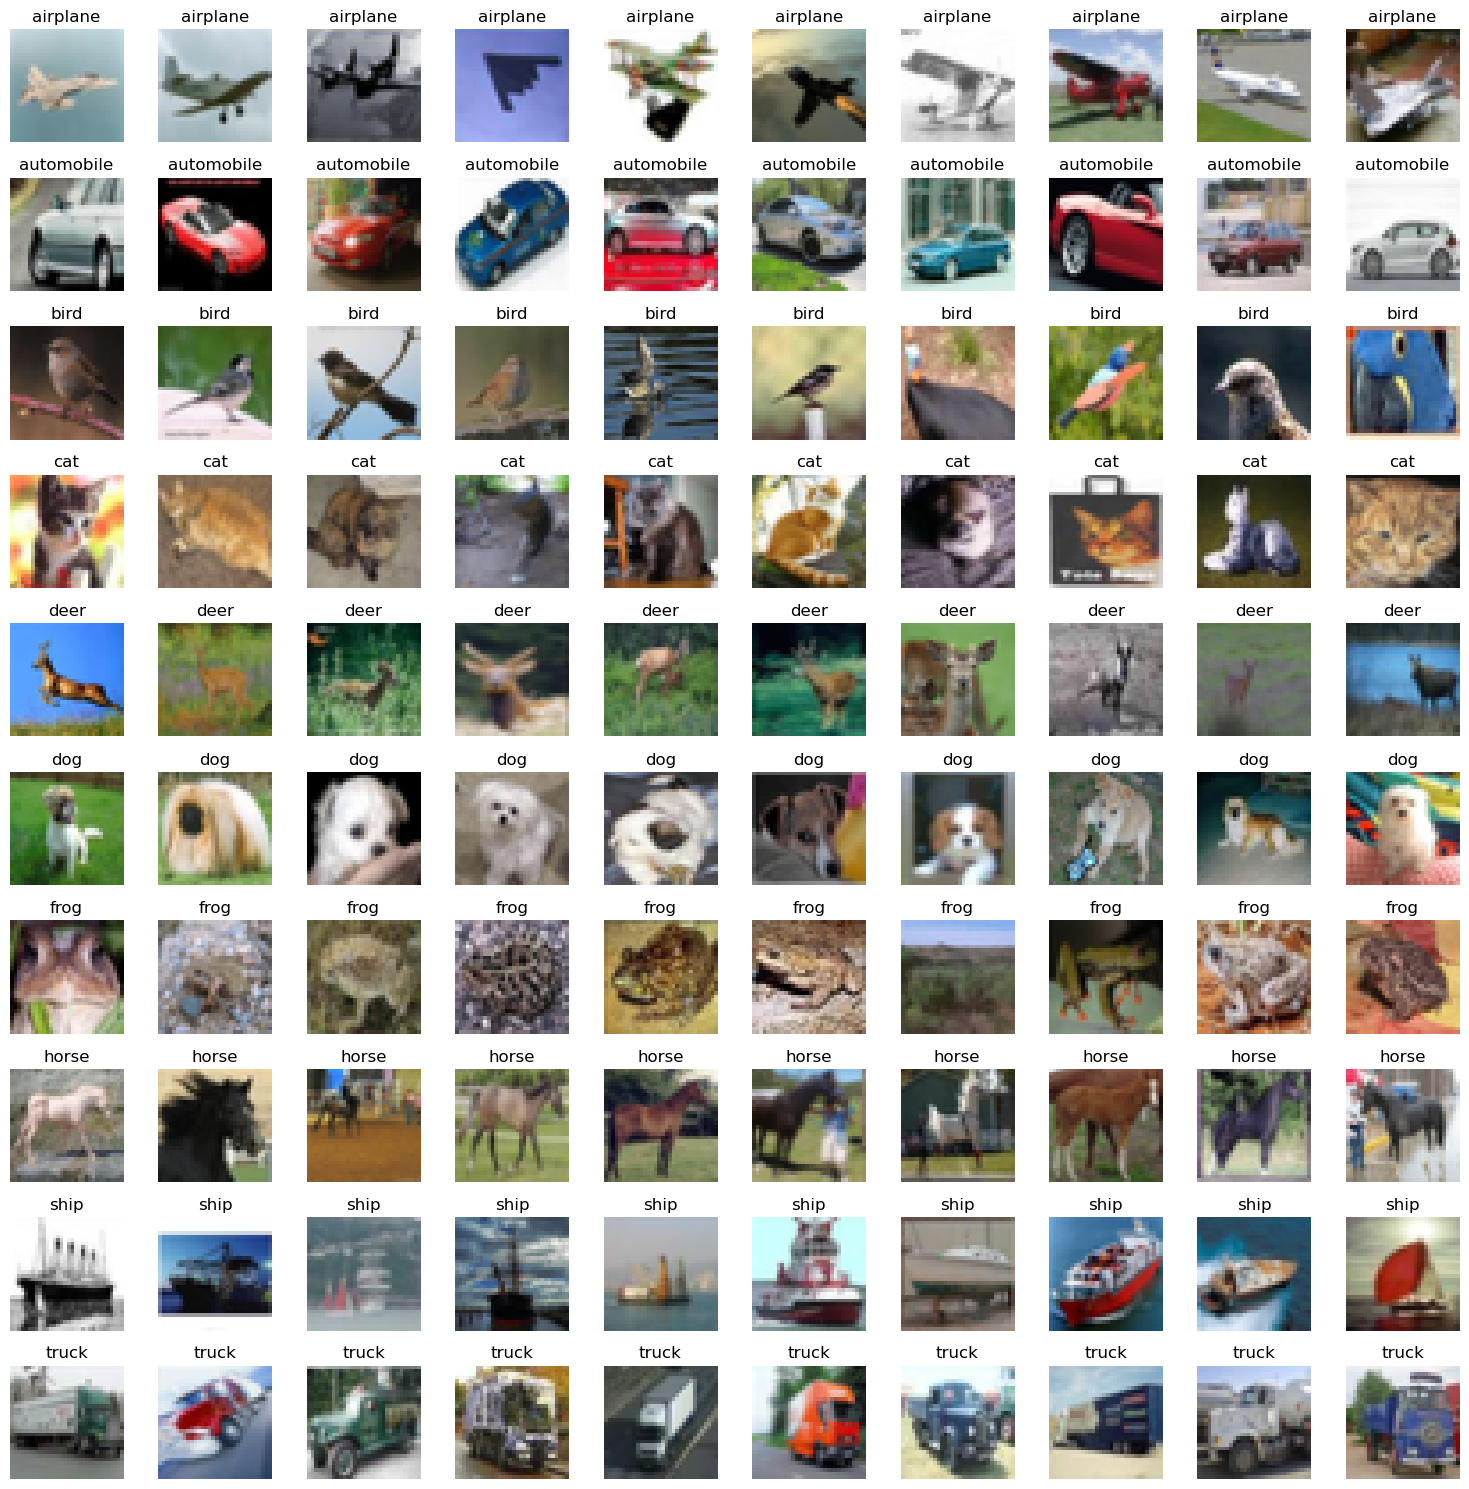

In [7]:
# Display random images from each class
display_random_images_per_class(x_train_full, y_train_full, classes)

In [8]:
# Split the dataset into training, validation, and testing sets
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=42)


In [9]:
# Define the CNN model
def build_model(hp):
    model = models.Sequential()
    model.add(layers.Conv2D(hp.Int('conv1_filters', min_value=32, max_value=128, step=16),
                             (3, 3),
                             activation='relu',
                             input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(hp.Int('conv2_filters', min_value=32, max_value=128, step=16),
                             (3, 3),
                             activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(hp.Int('conv3_filters', min_value=32, max_value=128, step=16),
                             (3, 3),
                             activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_units', min_value=32, max_value=128, step=16),
                            activation='relu'))
    model.add(layers.Dense(10))

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model


In [10]:
# Instantiate the Keras Tuner RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # number of hyperparameter combinations to try
    executions_per_trial=2,
    directory='hyperparameter_tuning',
    project_name='cifar10_cnn')

C:\Users\Dell\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [11]:
# Perform hyperparameter tuning
tuner.search(x_train, y_train,
             epochs=10,
             validation_data=(x_val, y_val))


Trial 5 Complete [00h 09m 24s]
val_accuracy: 0.10315000265836716

Best val_accuracy So Far: 0.6567000150680542
Total elapsed time: 00h 51m 48s


In [13]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [14]:
# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

In [15]:
# Train the model
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.2819 - loss: 1.9553 - val_accuracy: 0.4400 - val_loss: 1.5573
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 36ms/step - accuracy: 0.4691 - loss: 1.4794 - val_accuracy: 0.5189 - val_loss: 1.3576
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.5252 - loss: 1.3339 - val_accuracy: 0.5472 - val_loss: 1.2805
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.5538 - loss: 1.2626 - val_accuracy: 0.5767 - val_loss: 1.2091
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.5843 - loss: 1.1854 - val_accuracy: 0.5954 - val_loss: 1.1553
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.6097 - loss: 1.1219 - val_accuracy: 0.6127 - val_loss: 1.1127
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.6250 - loss: 1.0764 - val_accuracy: 0.6164 - val_loss: 1.0862
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 37ms/step - accuracy: 0.6432 -

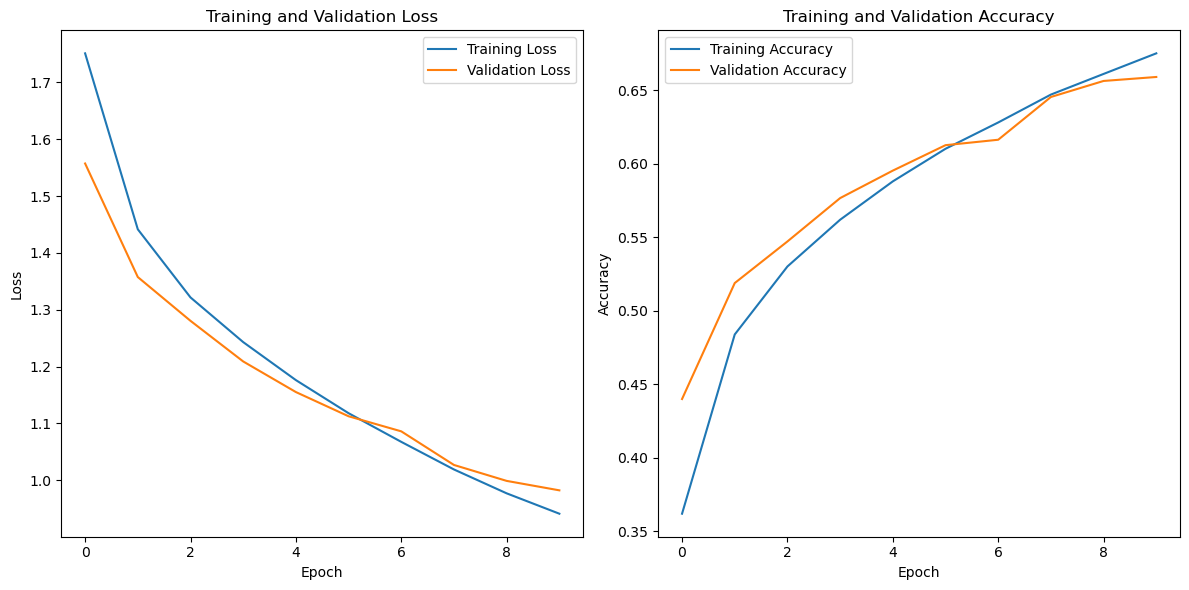

In [16]:
# Plot the training and validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(x_val, y_val, verbose=2)
print('\nValidation accuracy:', val_acc)

# Predict classes for validation set
y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute and print classification report
report = classification_report(y_val, y_pred_classes, target_names=classes)
print("\nClassification Report:\n", report)

313/313 - 4s - 12ms/step - accuracy: 0.6591 - loss: 0.9824

Validation accuracy: 0.6590999960899353
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step

Classification Report:
               precision    recall  f1-score   support

    airplane       0.61      0.77      0.68       973
  automobile       0.80      0.71      0.76       979
        bird       0.60      0.47      0.53      1030
         cat       0.52      0.49      0.51      1023
        deer       0.59      0.62      0.60       933
         dog       0.65      0.45      0.53      1015
        frog       0.70      0.76      0.73       996
       horse       0.65      0.73      0.69       994
        ship       0.77      0.78      0.78      1017
       truck       0.71      0.80      0.75      1040

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.65     10000
weighted avg       0.66      0.66      0.65     10000



In [19]:
# Calculate top-5 accuracy
top_5_accuracy = np.mean(top_k_categorical_accuracy(y_val, y_pred, k=5))
print("Top-5 Accuracy:", top_5_accuracy)

Top-5 Accuracy: 0.5574


In [20]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)
print("\nConfusion Matrix:\n", conf_matrix)


Confusion Matrix:
 [[750  22  24  15  19   5   9  12  72  45]
 [ 63 699   2   7  14   3   7   7  42 135]
 [126  12 488  72 102  46  81  55  29  19]
 [ 30   8  79 503  65 121 115  62  15  25]
 [ 41   8  56  34 581  21  58 111  14   9]
 [ 15   9  84 212  61 459  38 109   9  19]
 [ 16  10  50  44  57  15 758  11  13  22]
 [ 27   3  19  51  84  32  11 730   8  29]
 [115  31   8  17   3   2   1   3 795  42]
 [ 52  68   7  14   7   1   8  18  37 828]]


In [22]:
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve((y_val == i).astype(int), y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

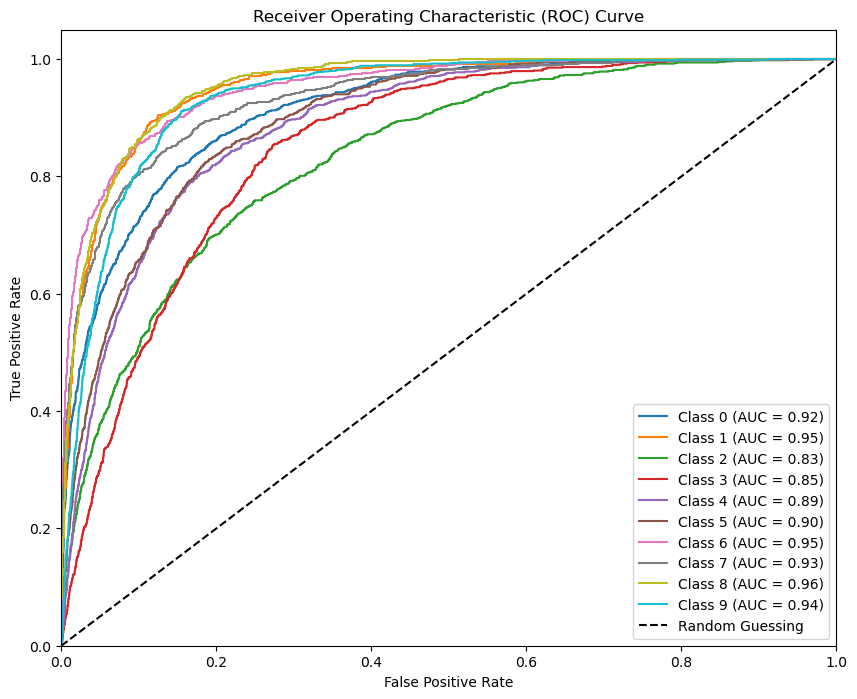

In [23]:
# Plot ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [24]:
# Calculate overall AUC
y_val_categorical = tf.keras.utils.to_categorical(y_val)
overall_auc = roc_auc_score(y_val_categorical, y_pred)
print("\nOverall AUC:", overall_auc)


Overall AUC: 0.9115502964951103
